In [21]:
#Importar librerias necesarias:
import cv2 #OpenCV para procesamiento de imagenes
import numpy as np #Numpy para operaciones numericas
import matplotlib.pyplot as plt #Matplotlib para visualizacion de imagenes  
from IPython.display import display, Markdown #Para mostrar markdown en Jupyter notebooks
import os #Para operaciones del sistema operativo
import random #Para operaciones aleatorias

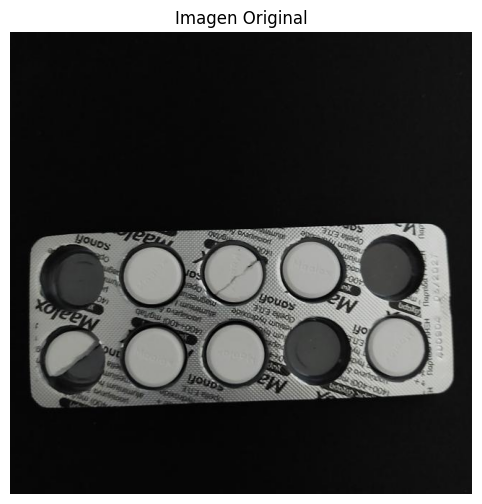

Dimensiones de la imagen original: (640, 640, 3)


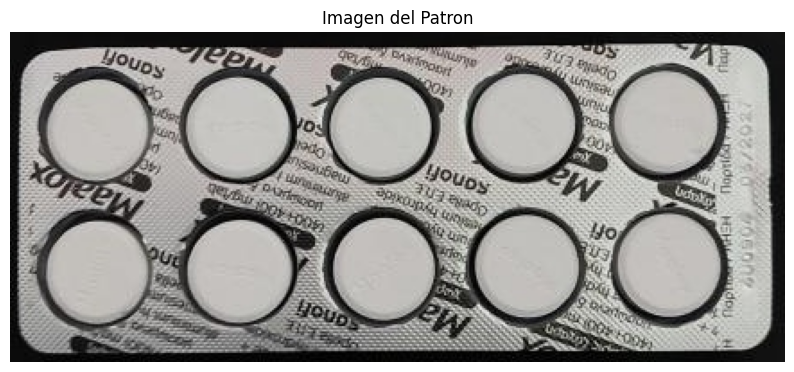

Dimensiones de la imagen del patron: (184, 432, 3)


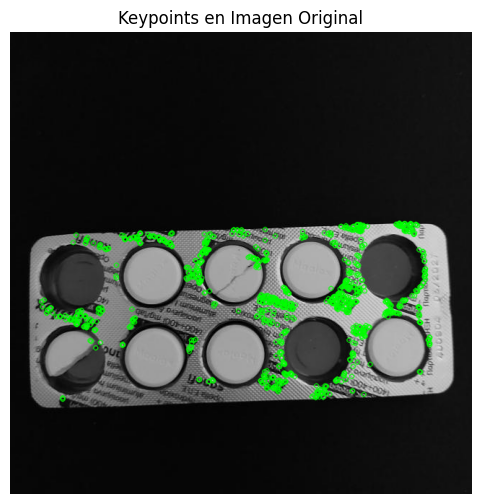

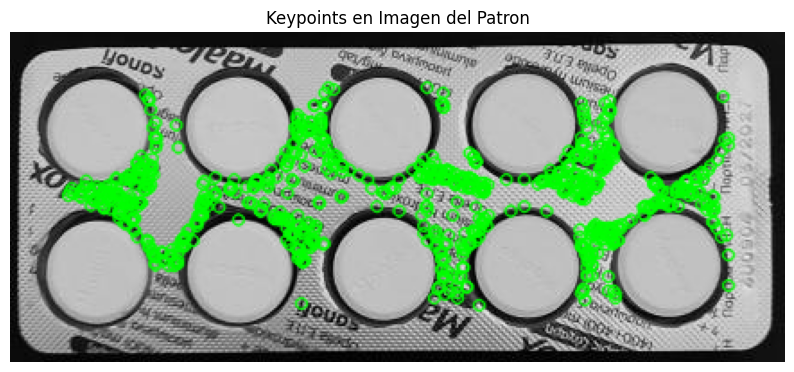

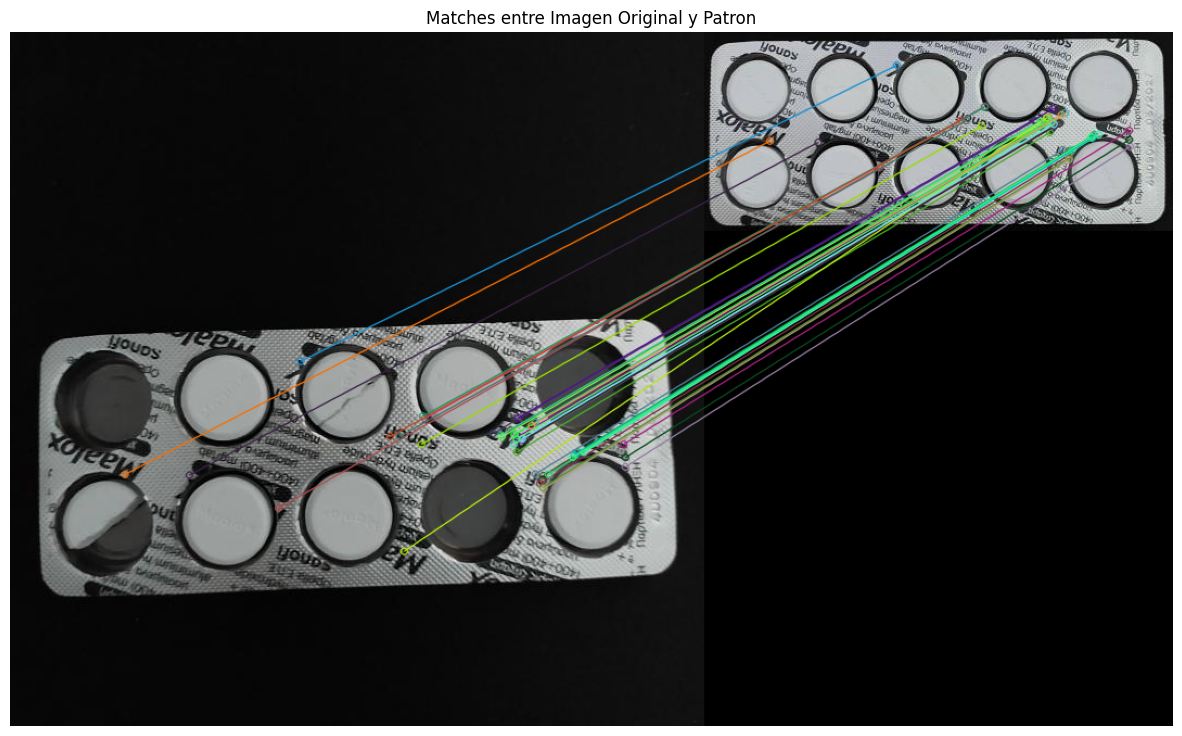

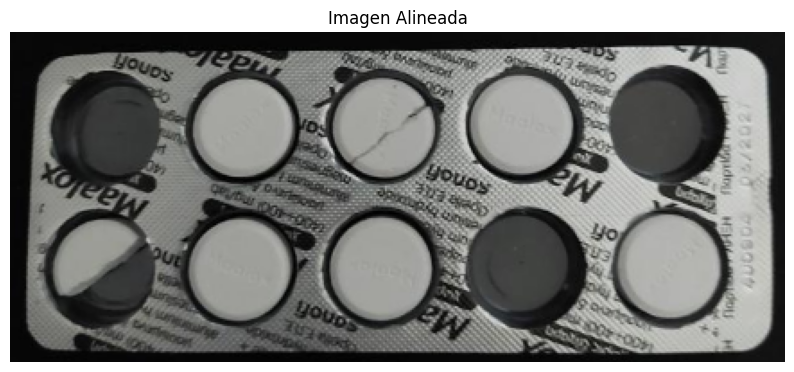

In [29]:
#--- Mostrar imagen original aleatoria ---
folder_path = "valid/images/" #Carpeta con imagenes de validacion
#Seleccionar imagen aleatoria de la carpeta ramdom.choice para elegir un elemento aleatorio de una lista 
# os.listdir para listar los archivos en la carpeta
imagen = random.choice(os.listdir(folder_path)) 
img = cv2.imread(os.path.join(folder_path, imagen)) #Leer la imagen seleccionada
img_patron = cv2.imread("blister_recortado.jpg") #Leer la imagen del patron
plt.figure(figsize=(10,6))#Tamaño de la figura 10x6 pulgadas
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) #Convertir de BGR a RGB para mostrar correctamente
plt.axis('off') #Quitar ejes
plt.title('Imagen Original') #Titulo de la imagen
plt.show() #Mostrar la imagen
print("Dimensiones de la imagen original:", img.shape)
plt.figure(figsize=(10,6))#Tamaño de la figura 10x6 pulgadas
plt.imshow(cv2.cvtColor(img_patron, cv2.COLOR_BGR2RGB)) #Convertir de BGR a RGB para mostrar correctamente
plt.axis('off') #Quitar ejes    
plt.title('Imagen del Patron') #Titulo de la imagen
plt.show() #Mostrar la imagen
print("Dimensiones de la imagen del patron:", img_patron.shape)

#Encontrar el patron en la imagen original
#Extraer caracteristicas del patron usando 
#ORB (Oriented FAST and Rotated BRIEF)
#1 Convertir ambas imagenes a escala de grises
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_patron_gray = cv2.cvtColor(img_patron, cv2.COLOR_BGR2GRAY)
#2 Crear el objeto ORB y detectar keypoints y descriptores
orb = cv2.ORB_create(nfeatures=1000) #Crear objeto ORB con 1000 caracteristicas
keypoints1, descriptors1 = orb.detectAndCompute(img_gray, None) #Imagen original
keypoints2, descriptors2 = orb.detectAndCompute(img_patron_gray, None) #Imagen patron
#3 Dibujar los keypoints en ambas imagenes
img_keypoints1 = cv2.drawKeypoints(img_gray, keypoints1, None, color=(0,255,0), flags=0)
img_keypoints2 = cv2.drawKeypoints(img_patron_gray, keypoints2, None, color=(0,255,0), flags=0)
#4 Mostrar las imagenes con los keypoints
plt.figure(figsize=(10,6))
plt.imshow(img_keypoints1)
plt.axis('off')
plt.title('Keypoints en Imagen Original')
plt.show()

plt.figure(figsize=(10,6))
plt.imshow(img_keypoints2)
plt.axis('off')
plt.title('Keypoints en Imagen del Patron')
plt.show()

#Crear el objeto BFMatcher para emparejar descriptores
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
#Emparejar los descriptores
matches = bf.match(descriptors1, descriptors2)
#Ordenar los matches por distancia
matches = sorted(matches, key=lambda x: x.distance)
#Filtrar los mejores matches
num_good_matches = int(len(matches) * 0.15) #Tomar el 15% mejores matches
good_matches = matches[:num_good_matches]
#mostrar los matches
img_matches = cv2.drawMatches(img, keypoints1, img_patron, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(15,10))
plt.imshow(img_matches)
plt.axis('off')
plt.title('Matches entre Imagen Original y Patron')
plt.show()
#Alinacion de la imagen usando los matches
# Crear listas de puntos clave
points1 = np.zeros((len(good_matches), 2), dtype=np.float32) #lista de puntos en la imagen original de tamaño igual al numero de buenos matches y 2 columnas (x,y)
points2 = np.zeros((len(good_matches), 2), dtype=np.float32) #lista de puntos en la imagen del patron
for i, match in enumerate(good_matches): #Iterar sobre los buenos matches
    points1[i, :] = keypoints1[match.queryIdx].pt #Obtener las coordenadas (x,y) del keypoint en la imagen original
    points2[i, :] = keypoints2[match.trainIdx].pt #Obtener las coordenadas (x,y) del keypoint en la imagen del patron
# Calcular la matriz de homografia
h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)
# Obtener las dimensiones de la imagen del patron 
height, width = img_patron.shape[:2]
# Aplicar la homografia para alinear la imagen del patron con la imagen original
img_aligned = cv2.warpPerspective(img, h, (width, height))
plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(img_aligned, cv2.COLOR_BGR2RGB)) #Convertir de BGR a RGB para mostrar correctamente
plt.axis('off')
plt.title('Imagen Alineada')
plt.show()

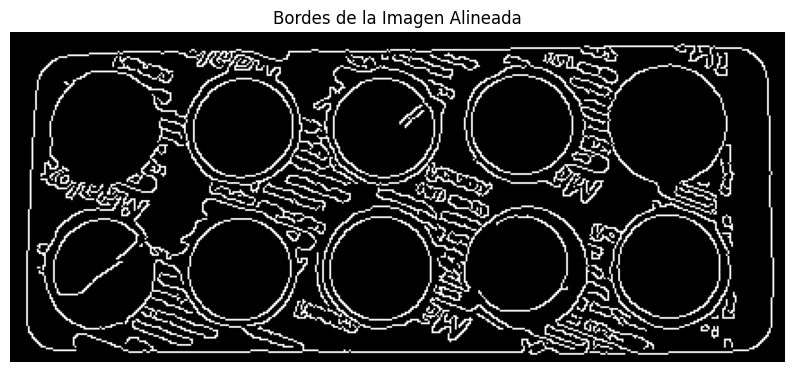

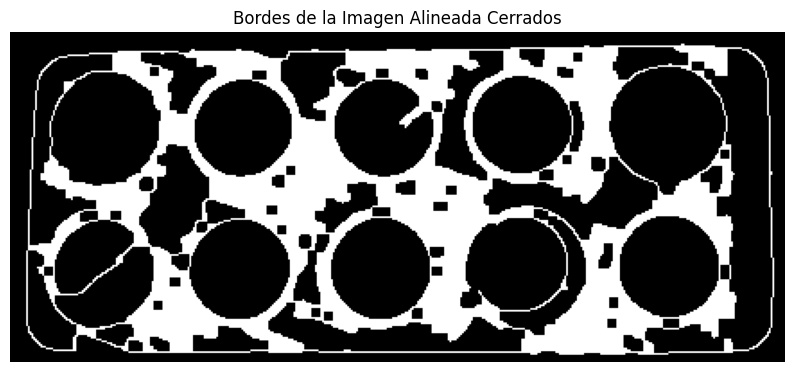

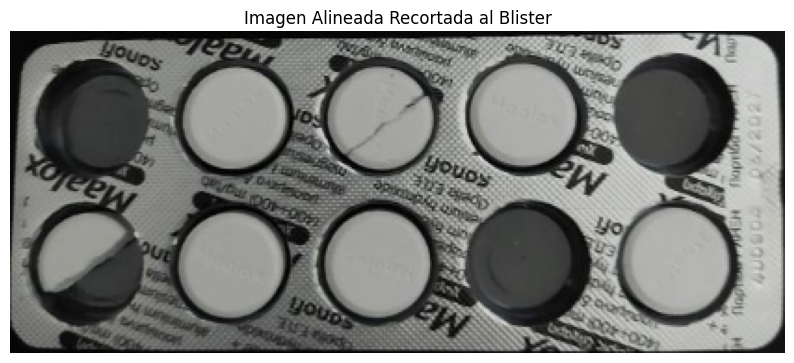

Dimensiones de la imagen alineada recortada al blister: (173, 417, 3)


In [30]:
#Econtrar contornos en la imagen alineada
img_aligned_gray = cv2.cvtColor(img_aligned, cv2.COLOR_BGR2GRAY)
img_aligned_blur = cv2.GaussianBlur(img_aligned_gray, (5, 5), 0)
img_aligned_edges = cv2.Canny(img_aligned_blur, 50, 150)
plt.figure(figsize=(10,6))
plt.imshow(img_aligned_edges, cmap='gray')
plt.axis('off')
plt.title('Bordes de la Imagen Alineada')
plt.show()
#cerrar y rellenar huecos en los bordes
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
img_aligned_edges = cv2.morphologyEx(img_aligned_edges, cv2.MORPH_CLOSE, kernel)
plt.figure(figsize=(10,6))
plt.imshow(img_aligned_edges, cmap='gray')
plt.axis('off')
plt.title('Bordes de la Imagen Alineada Cerrados')
plt.show()

contours,_ = cv2.findContours(img_aligned_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #Encontrar contornos en la imagen alineada
blister_aligned_contours = max(contours, key=cv2.contourArea) #Seleccionar el contorno mas grande (el blister)
x,y,w,h = cv2.boundingRect(blister_aligned_contours) #Obtener el rectangulo delimitador del contorno del blister
img_aligned_cropped = img_aligned[y:y+h, x:x+w] #Recortar la imagen al blister
plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(img_aligned_cropped, cv2.COLOR_BGR2RGB)) #Convertir de BGR a RGB para mostrar correctamente
plt.axis('off')
plt.title('Imagen Alineada Recortada al Blister')
plt.show()
print("Dimensiones de la imagen alineada recortada al blister:", img_aligned_cropped.shape)

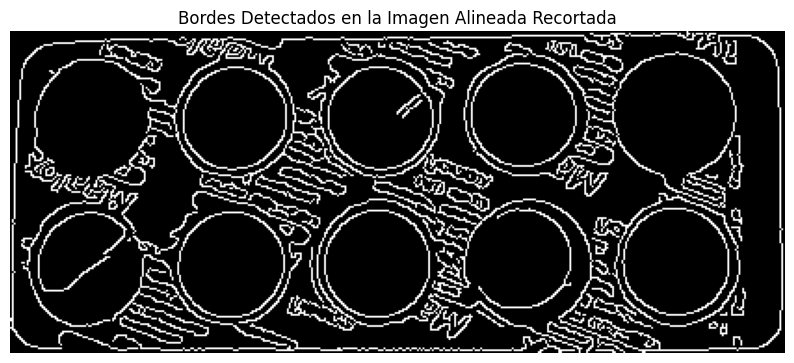

Numero de circulos detectados: 10


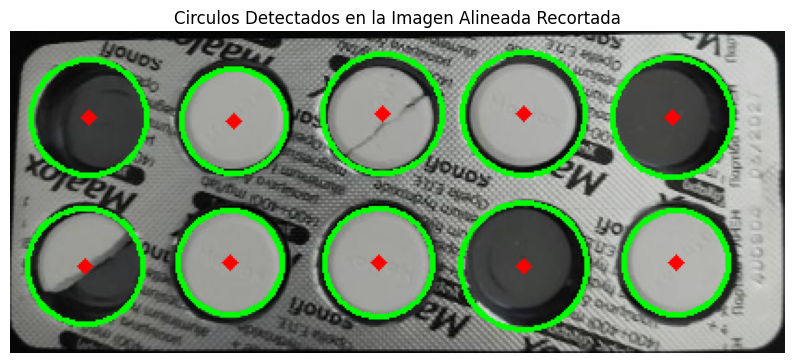

In [ ]:
#detectar circulos en la imagen alineada recortada
img_cropped_gray = cv2.cvtColor(img_aligned_cropped, cv2.COLOR_BGR2GRAY)
img_cropped_blur = cv2.GaussianBlur(img_cropped_gray, (5,5), 0)  
plt.figure(figsize=(10,6))
plt.imshow(img_cropped_blur, cmap='gray')
plt.axis('off')
plt.title('Imagen Alineada Recortada al Blister - Desenfocada')
plt.show()
img_aligned_edges = cv2.Canny(img_cropped_blur, 50, 150)
plt.figure(figsize=(10,6))
plt.imshow(img_aligned_edges, cmap='gray')
plt.axis('off')
plt.title('Bordes Detectados en la Imagen Alineada Recortada')
plt.show()

#HoighCircles parametros:
#dp: Resolucion inversa del acumulador
#minDist: Distancia minima entre centros de circulos detectados
#param1: Umbral superior para el detector de bordes Canny
#param2: Umbral para el acumulador de circulos
#minRadius: Radio minimo de los circulos a detectar
#maxRadius: Radio maximo de los circulos a detectar
circles = cv2.HoughCircles(img_aligned_edges,cv2.HOUGH_GRADIENT,dp=1,minDist=75,
    param1=100,param2=10,minRadius=25,maxRadius=35) #Detectar circulos con HoughCircles

#Si se detectan circulos, dibujarlos en la imagen
if circles is not None:
    circles = np.uint16(np.around(circles)) #Redondear las coordenadas de los circulos
    img_circles = img_aligned_cropped.copy() #Copiar la imagen alineada recortada
    for i in circles[0, :]: #Iterar sobre los circulos detectados
        # Dibujar el contorno del circulo
        cv2.circle(img_circles, (i[0], i[1]), i[2], (0, 255, 0), 2)
        # Dibujar el centro del circulo
        cv2.circle(img_circles, (i[0], i[1]), 2, (0, 0, 255), 3)

    
else:
    print("No se detectaron circulos en la imagen alineada recortada.")
print("Numero de circulos detectados:", len(circles[0]))
plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(img_circles, cv2.COLOR_BGR2RGB)) #Convertir de BGR a RGB para mostrar correctamente
plt.axis('off')
plt.title('Circulos Detectados en la Imagen Alineada Recortada')
plt.show()


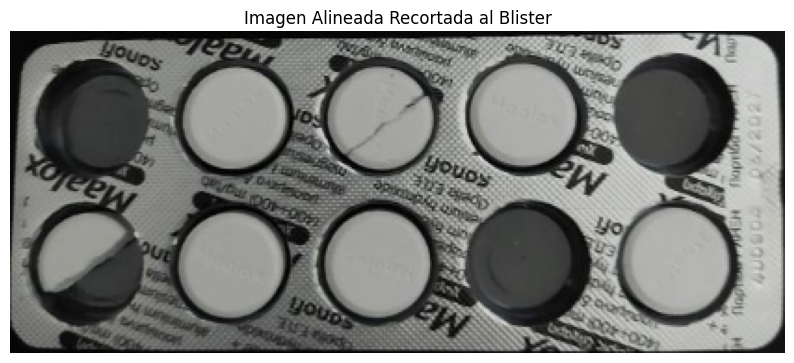

Dimensiones de la imagen alineada recortada al blister: (173, 417, 3)


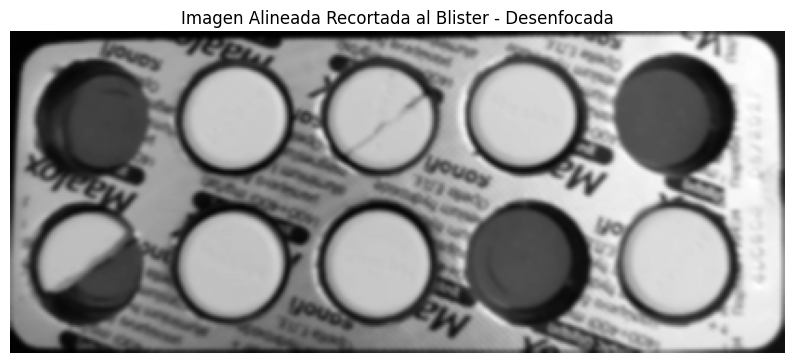

In [38]:
plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(img_aligned_cropped, cv2.COLOR_BGR2RGB)) #Convertir de BGR a RGB para mostrar correctamente
plt.axis('off')
plt.title('Imagen Alineada Recortada al Blister')
plt.show()
print("Dimensiones de la imagen alineada recortada al blister:", img_aligned_cropped.shape)

plt.figure(figsize=(10,6))
plt.imshow(img_cropped_blur, cmap='gray')
plt.axis('off')
plt.title('Imagen Alineada Recortada al Blister - Desenfocada')
plt.show()


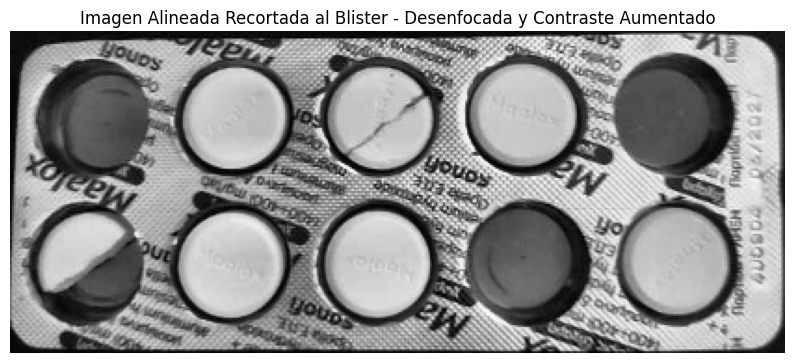

In [42]:
#Aumentar el contraste de la imagen alineada recortada al blister
img_cropped_blur_clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(img_cropped_gray)
plt.figure(figsize=(10,6))
plt.imshow(img_cropped_blur_clahe, cmap='gray')
plt.axis('off')
plt.title('Imagen Alineada Recortada al Blister - Desenfocada y Contraste Aumentado')
plt.show()



In [44]:
# Asegurar formato correcto (1 solo nivel)
circles = np.uint16(np.around(circles))
if circles.ndim == 3:
    circles = circles[0]
    
# --- CONFIGURACIÓN ---
UMBRAL_FRAC_CLARO = 0.40       # Fracción mínima para considerar completo
UMBRAL_INTENSIDAD_CLARO = 150 # Intensidad para considerar "claro"
UMBRAL_PARCIAL = 0.20         # Si está entre 0.20 y 0.40 => parcial

resultados = []

# --- PROCESAR CADA CÍRCULO ---
for i, (x_c, y_c, r_c) in enumerate(circles):

    # 1) Crear máscara circular (le restamos ligero margen)
    mask = np.zeros_like(img_cropped_blur_clahe, dtype=np.uint8)
    cv2.circle(mask, (x_c, y_c), max(r_c - 3, 1), 255, -1)

    # 2) Extraer región dentro del círculo
    region = img_cropped_blur_clahe[mask == 255]

    if region.size == 0:
        print(f"⚠️ Región vacía para el círculo {i} (posibles bordes fuera de imagen)")
        continue

    # 3) Histograma
    hist, bins = np.histogram(region, bins=256, range=(0,255))

    # Estadísticas adicionales
    intensidad_prom = region.mean()
    intensidad_min = region.min()
    intensidad_max = region.max()
    mediana = np.median(region)

    # % de píxeles claros
    pix_claros = np.sum(hist[UMBRAL_INTENSIDAD_CLARO:])
    fraccion_claros = pix_claros / region.size

    # 4) Clasificación
    if fraccion_claros > UMBRAL_FRAC_CLARO:
        estado = "completa"
    elif fraccion_claros > UMBRAL_PARCIAL:
        estado = "parcial / rota"
    else:
        estado = "vacía"

    # 5) Guardar resultados completos
    resultados.append({
        "id": i,
        "x": int(x_c),
        "y": int(y_c),
        "r": int(r_c),
        "fraccion_claros": float(fraccion_claros),
        "intensidad_promedio": float(intensidad_prom),
        "min": int(intensidad_min),
        "max": int(intensidad_max),
        "mediana": float(mediana),
        "pixeles": int(region.size),
        "estado": estado
    })

# --- IMPRIMIR RESULTADOS ---
for r in resultados:
    print(r)


{'id': 0, 'x': 276, 'y': 44, 'r': 33, 'fraccion_claros': 0.7965260545905707, 'intensidad_promedio': 172.00141793690182, 'min': 1, 'max': 216, 'mediana': 198.0, 'pixeles': 2821, 'estado': 'completa'}
{'id': 1, 'x': 358, 'y': 124, 'r': 28, 'fraccion_claros': 0.9949005609382968, 'intensidad_promedio': 190.5894951555329, 'min': 135, 'max': 214, 'mediana': 192.0, 'pixeles': 1961, 'estado': 'completa'}
{'id': 2, 'x': 198, 'y': 124, 'r': 29, 'fraccion_claros': 0.9985855728429985, 'intensidad_promedio': 208.4082979726544, 'min': 147, 'max': 231, 'mediana': 209.0, 'pixeles': 2121, 'estado': 'completa'}
{'id': 3, 'x': 200, 'y': 44, 'r': 32, 'fraccion_claros': 0.8193229364777482, 'intensidad_promedio': 175.3187523773298, 'min': 7, 'max': 222, 'mediana': 196.0, 'pixeles': 2629, 'estado': 'completa'}
{'id': 4, 'x': 118, 'y': 124, 'r': 28, 'fraccion_claros': 1.0, 'intensidad_promedio': 207.1412544620092, 'min': 168, 'max': 238, 'mediana': 208.0, 'pixeles': 1961, 'estado': 'completa'}
{'id': 5, 'x': 

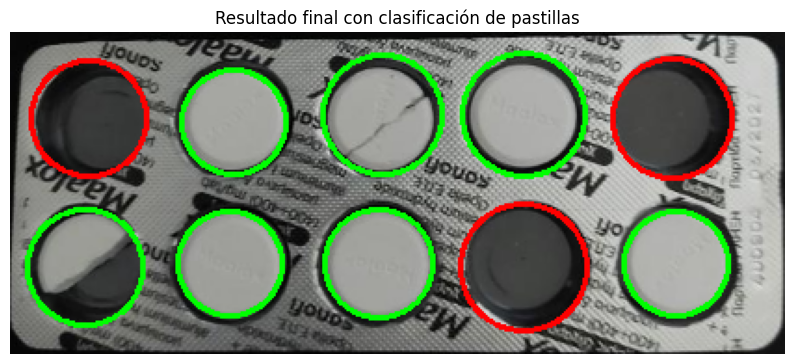

In [46]:
resultado_vis = img_aligned_cropped.copy()

# Colores por estado
colores = {
    "completa": (0, 255, 0),
    "pastilla parcial / rota": (0, 255, 255),
    "vacía": (0, 0, 255)
}

for (circle, res) in zip(circles, resultados):
    x_c, y_c, r_c = circle
    estado = res["estado"]  # usamos la nueva etiqueta

    color = colores.get(estado, (255, 255, 255))  # blanco si etiqueta desconocida

    # Dibujar círculo
    cv2.circle(resultado_vis, (x_c, y_c), r_c, color, 2)

plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(resultado_vis, cv2.COLOR_BGR2RGB)) #Convertir de BGR a RGB para mostrar correctamente
plt.axis('off')
plt.title('Resultado final con clasificación de pastillas')
plt.show()